### Setup

In [41]:
#Adjust the number of threads to your system
NT_shared = 8
NT_task = 32
Ngpu_runs = 10 #Set to 100 for more accurate results, much smaller standard deviation.
Ncpu_runs = 10 #Set to 100 for more accurate results, much smaller standard deviation.
Ncpu_warmup = 5 #Warmup caches and branch predictor.
Ngpu_warmup = 1 #No branch prediction on GPU, but if prefetching is disabled, the first run will fetch data.
#Change this number if the simulation is taking too long.
#Setting this number to -1 will reduce the batch sizes by 1 power of 2
OFFSET_BS = 0
omp_shared_setting = f"OMP_NUM_THREADS={int(NT_shared)} OMP_PROC_BIND=TRUE" 
omp_task_setting = f"OMP_NUM_THREADS={int(NT_task)} OMP_PROC_BIND=TRUE"

import matplotlib.pyplot as plt
import colorsys
from matplotlib import rcParams as rc
import numpy as np
import pandas as pd
import os

import subprocess
import platform

# Run the command and capture its output
if os.system('which nvidia-smi') == 0:
    output = subprocess.check_output(['nvidia-smi', '-L'])

    # Convert the byte string to a regular string
    output_str = output.decode('utf-8')

    # Count the number of lines in the output
    num_gpus = len(output_str.strip().split('\n'))
else:
    num_gpus = 0

hostname = platform.node()
# Print the number of GPUs found
print(f'Found {num_gpus} GPUs on {hostname}')

if not os.path.exists("output"):
    os.mkdir("output")

if not os.path.exists("output/" + hostname):
    os.mkdir("output/" + hostname)

if not os.path.exists("output/" + hostname + "/figures"):
    os.mkdir("output/" + hostname + "/figures")

rc["legend.markerscale"] = 2.0
rc["legend.framealpha"] = 0
rc["legend.labelspacing"] = 0.1
rc['figure.figsize'] = (20,10)
rc['axes.autolimit_mode'] = 'data'
rc['axes.xmargin'] = 0
rc['axes.ymargin'] = 0.10
rc['axes.titlesize'] = 30
rc['axes.labelsize'] = 24
rc['xtick.labelsize'] = 20
rc['ytick.labelsize'] = 20
rc['axes.grid'] = True
rc['grid.linestyle'] = '-'
rc['grid.alpha'] = 0.2
rc['legend.fontsize'] = 20
rc['legend.loc'] = 'upper left'
rc["figure.autolayout"] = True
rc["savefig.dpi"] = 300

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
CD = { "Baseline" : colors[0], "Shared" : colors[1], "Task" : colors[2], "GPU_V0" : colors[3], "GPU_V1" : colors[4], "2 GPU_V0" :  colors[5] ,"2 GPU_V1" : colors[6]}

def adjust_brightness(color, amount):
    """Adjust the brightness of a color by a given amount (-1 to 1)."""
    # Convert the color to the RGB color space
    r, g, b = tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    # Convert the color to the HLS color space
    h, l, s = colorsys.rgb_to_hls(r/255, g/255, b/255)
    # Modify the lightness value
    l = max(0, min(1, l + amount))
    # Convert the color back to RGB and return it
    r, g, b = tuple(round(c * 255) for c in colorsys.hls_to_rgb(h, l, s))
    return f"#{r:02x}{g:02x}{b:02x}"
# Modify the brightness of the colors
colors = [adjust_brightness(color, 0.2) for color in colors]

CD = { "Baseline" : 'r', "Shared" : colors[1], "Task" : colors[2], "GPU_V0" : colors[3], "GPU_V1" : colors[4], "2 GPU_V0" :  colors[5] ,"2 GPU_V1" : colors[0], "Dual" : f'#7570b3', "Generate" : f'#d95f02', "Projection" : f'#e7298a', "Tutte" : f'#66a61e', "Opt" : f'#8931EF' }

KName0 = r"SYCL Kernel 0"
KName1 = r"SYCL Kernel 1"
TaskName = r"OpenMP Task Parallel [$N_T$ = " + f"{NT_task}]"
SharedName = r"OpenMP Shared Memory [$N_T$ = " + f"{NT_shared}]"

/usr/bin/nvidia-smi
Found 2 GPUs on threadripper00


### Create files to store results, if they already exist, empty them.

In [2]:
path = f'/{os.getcwd()}/output/{hostname}/'
buildpath = f'/{os.getcwd()}/build/'
fname_base = f'{path}base.csv'
fname_one_gpu_v0 = f'{path}one_gpu_v0.csv'
fname_one_gpu_v1 = f'{path}one_gpu_v1.csv'
fname_multi_gpu_v0 = f'{path}multi_gpu_v0.csv'
fname_multi_gpu_v1 = f'{path}multi_gpu_v1.csv'
fname_multi_gpu_weak = f'{path}multi_gpu_weak.csv'
fname_omp_shared = f'{path}omp_shared.csv'
fname_omp_task = f'{path}omp_task.csv'

def source_and_get_environment(script_path, base_environment=None):
    """Source script and return the updated environment."""
    if base_environment is None:
        base_environment = os.environ.copy()
    command = ['/bin/bash', '-c', f'source {script_path} && env']
    proc = subprocess.Popen(command, stdout=subprocess.PIPE, env=base_environment)
    output, _ = proc.communicate()
    env = dict((line.split("=", 1) for line in output.decode().splitlines() if "=" in line))
    return env

env = source_and_get_environment('/opt/intel/oneapi/setvars.sh')



In [4]:
def reset_file(filename):
    # Check if the file already exists
    if os.path.isfile(filename):
        # If it does, empty it by opening it in write mode with the 'truncate' option
        with open(filename, 'w', newline='') as f:
            f.truncate()
    else:
        # If it doesn't, create an empty file by opening it in write mode
        with open(filename, 'w', newline='') as f:
            pass

reset_file(fname_base)
reset_file(fname_one_gpu_v0)
reset_file(fname_one_gpu_v1)
reset_file(fname_multi_gpu_v0)
reset_file(fname_multi_gpu_v1)
reset_file(fname_multi_gpu_weak)
reset_file(fname_omp_shared)
reset_file(fname_omp_task)



### Run the batch size experiment

In [ ]:
fname_omp_shared_bs = f'{path}omp_shared_bs.csv'
fname_omp_task_bs = f'{path}omp_task_bs.csv'
fname_single_gpu_bs = f'{path}single_gpu_bs.csv'
reset_file(fname_omp_shared_bs)
reset_file(fname_omp_task_bs)
reset_file(fname_single_gpu_bs)


for i in range(0,20):
    if(num_gpus>0):
        proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/dualisation gpu {200} {2**(i)} {Ngpu_runs} {Ngpu_warmup} 1 1 {fname_single_gpu_bs}'], env=env); proc.wait()

### Plot the batch size experiment

In [ ]:
#df_omp_shared_bs = pd.read_csv(fname_omp_shared_bs)
#df_omp_task_bs = pd.read_csv(fname_omp_task_bs)
df_single_gpu_bs = pd.read_csv(fname_single_gpu_bs)

import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset)
fig,ax = plt.subplots(figsize=(15,10))
def add_line(ax, BS, T, SD, label, color, marker, linestyle):
    ax.plot(BS, T, marker=marker, color=color, label=label, linestyle=linestyle)
    ax.fill_between(BS, T - SD, T + SD, alpha=0.1, color='k')
 
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Time / Graph [ns]")
ax.set_xlabel("Batch Size [1]")
if(num_gpus>0):
    add_line(ax, df_single_gpu_bs["BS"].to_numpy(), df_single_gpu_bs["T"].to_numpy(), df_single_gpu_bs["TSD"].to_numpy(), "Lockstep Parallel Dualization", CD["GPU_V1"], 'o', ':')
ax.legend(loc='best')
plt.savefig(f'{path}figures/batch_size_benchmark.pdf', bbox_inches='tight')

### Run the benchmarks

In [80]:
reset_file(fname_base)
reset_file(fname_one_gpu_v0)
reset_file(fname_one_gpu_v1)
reset_file(fname_multi_gpu_v0)
reset_file(fname_multi_gpu_v1)
reset_file(fname_omp_shared)
reset_file(fname_omp_task)
reset_file(fname_multi_gpu_weak)

import subprocess
import os

def source_and_get_environment(script_path, base_environment=None):
    """Source script and return the updated environment."""
    if base_environment is None:
        base_environment = os.environ.copy()
    command = ['/bin/bash', '-c', f'source {script_path} && env']
    proc = subprocess.Popen(command, stdout=subprocess.PIPE, env=base_environment)
    output, _ = proc.communicate()
    env = dict((line.split("=", 1) for line in output.decode().splitlines() if "=" in line))
    return env

env = source_and_get_environment('/opt/intel/oneapi/setvars.sh')

for i in range(20,201,2):
    os.system(f'{buildpath}benchmarks/baseline {i} {2**(6+OFFSET_BS)} {Ncpu_runs} {Ncpu_warmup} 0 {fname_base}')
    if(num_gpus>0):
        proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/dualisation gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 0 1 {fname_one_gpu_v0}'], env=env);  proc.wait()
        proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/dualisation gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 1 1 {fname_one_gpu_v1}'], env=env); proc.wait()
        proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/dualisation gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 0 {num_gpus} {fname_multi_gpu_v0}'], env=env); proc.wait()
        proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/dualisation gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 1 {num_gpus} {fname_multi_gpu_v1}'], env=env); proc.wait()
        proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/dualisation gpu {i} {num_gpus*2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 1 {num_gpus} {fname_multi_gpu_weak}'], env=env); proc.wait()



Dualising 64 triangulation graphs, each with 20 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 13052.2 +/- 36.432 ns
Dualising 1048576 triangulation graphs, each with 20 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274372
UID: 1002
[Thu Dec  7 20:22:35 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 6.16956 +/- 0.0065349 ns
Dualising 1048576 triangulation graphs, each with 20 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274383
UID: 1002
[Thu Dec  7 20:22:36 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.80085 +/- 0.00974957 ns
Dualising 1048576 triangulation graphs, each with 20 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274393
UID: 1002
[Thu Dec  7 20:22:37 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 3.12151 +/- 0.00952098 ns
Dualising 1048576 triangulation graphs, each with 20 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274403
UID: 1002
[Thu Dec  7 20:22:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 3.44232 +/- 0.0133263 ns
Dualising 2097152 triangulation graphs, each with 20 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274413
UID: 1002
[Thu Dec  7 20:22:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 3.41169 +/- 0.00650003 ns
Dualising 64 triangulation graphs, each with 22 triangles, repeated 10 times and with 5 warmup runs.
N must be even and between 20 and 200 and not equal to 22.
Dualising 1048576 triangulation graphs, each with 22 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274430
UID: 1002
[Thu Dec  7 20:22:40 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
N must be even and between 20 and 200 and not equal to 22.
Dualising 1048576 triangulation graphs, each with 22 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274440
UID: 1002
[Thu Dec  7 20:22:40 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
N must be even and between 20 and 200 and not equal to 22.
Dualising 1048576 triangulation graphs, each with 22 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274450
UID: 1002
[Thu Dec  7 20:22:41 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
N must be even and between 20 and 200 and not equal to 22.
Dualising 1048576 triangulation graphs, each with 22 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274460
UID: 1002
[Thu Dec  7 20:22:41 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
N must be even and between 20 and 200 and not equal to 22.
Dualising 2097152 triangulation graphs, each with 22 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274470
UID: 1002
[Thu Dec  7 20:22:42 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
N must be even and between 20 and 200 and not equal to 22.
Dualising 64 triangulation graphs, each with 24 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 8919.58 +/- 239.344 ns
Dualising 1048576 triangulation graphs, each with 24 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274483
UID: 1002
[Thu Dec  7 20:22:42 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 7.28084 +/- 0.143948 ns
Dualising 1048576 triangulation graphs, each with 24 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274493
UID: 1002
[Thu Dec  7 20:22:43 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 7.19868 +/- 0.0147924 ns
Dualising 1048576 triangulation graphs, each with 24 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274503
UID: 1002
[Thu Dec  7 20:22:44 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 3.68758 +/- 0.0101039 ns
Dualising 1048576 triangulation graphs, each with 24 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274514
UID: 1002
[Thu Dec  7 20:22:45 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.09926 +/- 0.0135166 ns
Dualising 2097152 triangulation graphs, each with 24 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274524
UID: 1002
[Thu Dec  7 20:22:46 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.0675 +/- 0.00623313 ns
Dualising 64 triangulation graphs, each with 26 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 9342.27 +/- 107.711 ns
Dualising 1048576 triangulation graphs, each with 26 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274537
UID: 1002
[Thu Dec  7 20:22:48 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 7.34624 +/- 0.0468523 ns
Dualising 1048576 triangulation graphs, each with 26 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274547
UID: 1002
[Thu Dec  7 20:22:49 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 7.26299 +/- 0.0103476 ns
Dualising 1048576 triangulation graphs, each with 26 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274557
UID: 1002
[Thu Dec  7 20:22:50 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 3.7132 +/- 0.00961509 ns
Dualising 1048576 triangulation graphs, each with 26 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274568
UID: 1002
[Thu Dec  7 20:22:51 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.13054 +/- 0.0135153 ns
Dualising 2097152 triangulation graphs, each with 26 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274578
UID: 1002
[Thu Dec  7 20:22:52 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.1027 +/- 0.00631066 ns
Dualising 64 triangulation graphs, each with 28 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 24344.6 +/- 139.363 ns
Dualising 1048576 triangulation graphs, each with 28 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274591
UID: 1002
[Thu Dec  7 20:22:54 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 6.46106 +/- 0.0253164 ns
Dualising 1048576 triangulation graphs, each with 28 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274601
UID: 1002
[Thu Dec  7 20:22:55 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 8.1609 +/- 0.0108449 ns
Dualising 1048576 triangulation graphs, each with 28 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274611
UID: 1002
[Thu Dec  7 20:22:56 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 3.68203 +/- 0.0100537 ns
Dualising 1048576 triangulation graphs, each with 28 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274622
UID: 1002
[Thu Dec  7 20:22:57 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.12306 +/- 0.0135125 ns
Dualising 2097152 triangulation graphs, each with 28 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274632
UID: 1002
[Thu Dec  7 20:22:59 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.08971 +/- 0.0100716 ns
Dualising 64 triangulation graphs, each with 30 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 20357.3 +/- 56.3049 ns
Dualising 1048576 triangulation graphs, each with 30 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274645
UID: 1002
[Thu Dec  7 20:23:01 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 6.65606 +/- 0.0589856 ns
Dualising 1048576 triangulation graphs, each with 30 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274655
UID: 1002
[Thu Dec  7 20:23:02 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 8.38235 +/- 0.0100417 ns
Dualising 1048576 triangulation graphs, each with 30 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274666
UID: 1002
[Thu Dec  7 20:23:03 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 3.77282 +/- 0.0112629 ns
Dualising 1048576 triangulation graphs, each with 30 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274676
UID: 1002
[Thu Dec  7 20:23:04 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.23467 +/- 0.0121318 ns
Dualising 2097152 triangulation graphs, each with 30 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274686
UID: 1002
[Thu Dec  7 20:23:05 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.20393 +/- 0.00661644 ns
Dualising 64 triangulation graphs, each with 32 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 12522.7 +/- 64.608 ns
Dualising 1048576 triangulation graphs, each with 32 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274699
UID: 1002
[Thu Dec  7 20:23:07 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 6.6723 +/- 0.0460397 ns
Dualising 1048576 triangulation graphs, each with 32 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274709
UID: 1002
[Thu Dec  7 20:23:08 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 7.50304 +/- 0.0099975 ns
Dualising 1048576 triangulation graphs, each with 32 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274720
UID: 1002
[Thu Dec  7 20:23:10 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 3.78112 +/- 0.00901137 ns
Dualising 1048576 triangulation graphs, each with 32 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274730
UID: 1002
[Thu Dec  7 20:23:11 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.2694 +/- 0.0144894 ns
Dualising 2097152 triangulation graphs, each with 32 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274741
UID: 1002
[Thu Dec  7 20:23:12 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 4.23338 +/- 0.00883105 ns
Dualising 64 triangulation graphs, each with 34 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 14208.1 +/- 1068.09 ns
Dualising 1048576 triangulation graphs, each with 34 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274753
UID: 1002
[Thu Dec  7 20:23:14 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.65746 +/- 0.0596589 ns
Dualising 1048576 triangulation graphs, each with 34 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274764
UID: 1002
[Thu Dec  7 20:23:16 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 9.41653 +/- 0.0287423 ns
Dualising 1048576 triangulation graphs, each with 34 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274774
UID: 1002
[Thu Dec  7 20:23:17 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.90402 +/- 0.00889197 ns
Dualising 1048576 triangulation graphs, each with 34 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274785
UID: 1002
[Thu Dec  7 20:23:18 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.30997 +/- 0.012903 ns
Dualising 2097152 triangulation graphs, each with 34 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274795
UID: 1002
[Thu Dec  7 20:23:20 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.27783 +/- 0.0102055 ns
Dualising 64 triangulation graphs, each with 36 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 15096.1 +/- 307.593 ns
Dualising 1048576 triangulation graphs, each with 36 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274808
UID: 1002
[Thu Dec  7 20:23:22 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.77355 +/- 0.0871245 ns
Dualising 1048576 triangulation graphs, each with 36 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274818
UID: 1002
[Thu Dec  7 20:23:23 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 9.98415 +/- 0.0255909 ns
Dualising 1048576 triangulation graphs, each with 36 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274829
UID: 1002
[Thu Dec  7 20:23:25 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.9152 +/- 0.00971637 ns
Dualising 1048576 triangulation graphs, each with 36 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274839
UID: 1002
[Thu Dec  7 20:23:26 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.64579 +/- 0.0128274 ns
Dualising 2097152 triangulation graphs, each with 36 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274850
UID: 1002
[Thu Dec  7 20:23:27 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.60944 +/- 0.00864591 ns
Dualising 64 triangulation graphs, each with 38 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 25550.1 +/- 935.725 ns
Dualising 1048576 triangulation graphs, each with 38 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274863
UID: 1002
[Thu Dec  7 20:23:30 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.7923 +/- 0.110776 ns
Dualising 1048576 triangulation graphs, each with 38 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274873
UID: 1002
[Thu Dec  7 20:23:31 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.0991 +/- 0.0357154 ns
Dualising 1048576 triangulation graphs, each with 38 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274883
UID: 1002
[Thu Dec  7 20:23:33 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.91026 +/- 0.00991143 ns
Dualising 1048576 triangulation graphs, each with 38 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274894
UID: 1002
[Thu Dec  7 20:23:34 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.67215 +/- 0.0120177 ns
Dualising 2097152 triangulation graphs, each with 38 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274904
UID: 1002
[Thu Dec  7 20:23:36 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.66184 +/- 0.0114575 ns
Dualising 64 triangulation graphs, each with 40 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 31432.7 +/- 979.066 ns
Dualising 1048576 triangulation graphs, each with 40 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274917
UID: 1002
[Thu Dec  7 20:23:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.81422 +/- 0.12803 ns
Dualising 1048576 triangulation graphs, each with 40 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274928
UID: 1002
[Thu Dec  7 20:23:40 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.3861 +/- 0.0263783 ns
Dualising 1048576 triangulation graphs, each with 40 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274938
UID: 1002
[Thu Dec  7 20:23:41 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.90922 +/- 0.00976104 ns
Dualising 1048576 triangulation graphs, each with 40 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274949
UID: 1002
[Thu Dec  7 20:23:43 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.83797 +/- 0.0116672 ns
Dualising 2097152 triangulation graphs, each with 40 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274959
UID: 1002
[Thu Dec  7 20:23:44 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.82922 +/- 0.00631516 ns
Dualising 64 triangulation graphs, each with 42 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 35952.8 +/- 509.619 ns
Dualising 1048576 triangulation graphs, each with 42 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274972
UID: 1002
[Thu Dec  7 20:23:47 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.84348 +/- 0.150465 ns
Dualising 1048576 triangulation graphs, each with 42 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274983
UID: 1002
[Thu Dec  7 20:23:48 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.4476 +/- 0.0210833 ns
Dualising 1048576 triangulation graphs, each with 42 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1274993
UID: 1002
[Thu Dec  7 20:23:50 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.91754 +/- 0.00892562 ns
Dualising 1048576 triangulation graphs, each with 42 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275004
UID: 1002
[Thu Dec  7 20:23:51 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.86818 +/- 0.0132148 ns
Dualising 2097152 triangulation graphs, each with 42 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275014
UID: 1002
[Thu Dec  7 20:23:53 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.85969 +/- 0.00638672 ns
Dualising 64 triangulation graphs, each with 44 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 48383 +/- 4823.43 ns
Dualising 1048576 triangulation graphs, each with 44 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275027
UID: 1002
[Thu Dec  7 20:23:55 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.85042 +/- 0.162726 ns
Dualising 1048576 triangulation graphs, each with 44 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275038
UID: 1002
[Thu Dec  7 20:23:57 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.7249 +/- 0.0298956 ns
Dualising 1048576 triangulation graphs, each with 44 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275048
UID: 1002
[Thu Dec  7 20:23:58 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.90248 +/- 0.00939641 ns
Dualising 1048576 triangulation graphs, each with 44 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275059
UID: 1002
[Thu Dec  7 20:24:00 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.01434 +/- 0.0118824 ns
Dualising 2097152 triangulation graphs, each with 44 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275069
UID: 1002
[Thu Dec  7 20:24:02 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.00512 +/- 0.005669 ns
Dualising 64 triangulation graphs, each with 46 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 47339.2 +/- 546.07 ns
Dualising 1048576 triangulation graphs, each with 46 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275082
UID: 1002
[Thu Dec  7 20:24:04 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.89689 +/- 0.157674 ns
Dualising 1048576 triangulation graphs, each with 46 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275093
UID: 1002
[Thu Dec  7 20:24:06 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.6664 +/- 0.020792 ns
Dualising 1048576 triangulation graphs, each with 46 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275103
UID: 1002
[Thu Dec  7 20:24:08 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.91697 +/- 0.00965136 ns
Dualising 1048576 triangulation graphs, each with 46 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275114
UID: 1002
[Thu Dec  7 20:24:09 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.99533 +/- 0.0119439 ns
Dualising 2097152 triangulation graphs, each with 46 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275124
UID: 1002
[Thu Dec  7 20:24:11 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 5.98379 +/- 0.00680174 ns
Dualising 64 triangulation graphs, each with 48 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 48802.1 +/- 121.611 ns
Dualising 1048576 triangulation graphs, each with 48 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275141
UID: 1002
[Thu Dec  7 20:24:14 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 8.85018 +/- 0.164991 ns
Dualising 1048576 triangulation graphs, each with 48 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275152
UID: 1002
[Thu Dec  7 20:24:15 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.7982 +/- 0.0301222 ns
Dualising 1048576 triangulation graphs, each with 48 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275162
UID: 1002
[Thu Dec  7 20:24:17 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.89963 +/- 0.0102221 ns
Dualising 1048576 triangulation graphs, each with 48 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275173
UID: 1002
[Thu Dec  7 20:24:19 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.04983 +/- 0.0123373 ns
Dualising 2097152 triangulation graphs, each with 48 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275184
UID: 1002
[Thu Dec  7 20:24:21 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.04261 +/- 0.00616552 ns
Dualising 64 triangulation graphs, each with 50 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 50191.5 +/- 447.478 ns
Dualising 1048576 triangulation graphs, each with 50 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275196
UID: 1002
[Thu Dec  7 20:24:24 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.77993 +/- 0.029234 ns
Dualising 1048576 triangulation graphs, each with 50 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275207
UID: 1002
[Thu Dec  7 20:24:25 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.8704 +/- 0.0221307 ns
Dualising 1048576 triangulation graphs, each with 50 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275218
UID: 1002
[Thu Dec  7 20:24:27 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.91921 +/- 0.0100768 ns
Dualising 1048576 triangulation graphs, each with 50 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275228
UID: 1002
[Thu Dec  7 20:24:29 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.09876 +/- 0.0122989 ns
Dualising 2097152 triangulation graphs, each with 50 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275239
UID: 1002
[Thu Dec  7 20:24:31 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.09664 +/- 0.0121779 ns
Dualising 64 triangulation graphs, each with 52 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 53096 +/- 2901.06 ns
Dualising 1048576 triangulation graphs, each with 52 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275252
UID: 1002
[Thu Dec  7 20:24:34 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.62628 +/- 0.219915 ns
Dualising 1048576 triangulation graphs, each with 52 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275263
UID: 1002
[Thu Dec  7 20:24:36 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.9213 +/- 0.0306773 ns
Dualising 1048576 triangulation graphs, each with 52 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275273
UID: 1002
[Thu Dec  7 20:24:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.90477 +/- 0.00988873 ns
Dualising 1048576 triangulation graphs, each with 52 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275284
UID: 1002
[Thu Dec  7 20:24:39 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.1161 +/- 0.0113433 ns
Dualising 2097152 triangulation graphs, each with 52 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275294
UID: 1002
[Thu Dec  7 20:24:41 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.0822 +/- 0.10162 ns
Dualising 64 triangulation graphs, each with 54 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 31354.8 +/- 330.396 ns
Dualising 1048576 triangulation graphs, each with 54 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275307
UID: 1002
[Thu Dec  7 20:24:44 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.68858 +/- 0.21352 ns
Dualising 1048576 triangulation graphs, each with 54 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275318
UID: 1002
[Thu Dec  7 20:24:46 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 10.8922 +/- 0.00928208 ns
Dualising 1048576 triangulation graphs, each with 54 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275329
UID: 1002
[Thu Dec  7 20:24:48 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.92137 +/- 0.0097259 ns
Dualising 1048576 triangulation graphs, each with 54 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275339
UID: 1002
[Thu Dec  7 20:24:50 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.1498 +/- 0.0701109 ns
Dualising 2097152 triangulation graphs, each with 54 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275350
UID: 1002
[Thu Dec  7 20:24:52 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.13964 +/- 0.0105954 ns
Dualising 64 triangulation graphs, each with 56 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 33126.5 +/- 337.925 ns
Dualising 1048576 triangulation graphs, each with 56 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275363
UID: 1002
[Thu Dec  7 20:24:55 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.62245 +/- 0.241379 ns
Dualising 1048576 triangulation graphs, each with 56 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275374
UID: 1002
[Thu Dec  7 20:24:57 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 12.3349 +/- 0.0100421 ns
Dualising 1048576 triangulation graphs, each with 56 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275384
UID: 1002
[Thu Dec  7 20:24:59 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.90668 +/- 0.00920328 ns
Dualising 1048576 triangulation graphs, each with 56 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275395
UID: 1002
[Thu Dec  7 20:25:01 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.21618 +/- 0.0129933 ns
Dualising 2097152 triangulation graphs, each with 56 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275409
UID: 1002
[Thu Dec  7 20:25:03 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.02367 +/- 0.23513 ns
Dualising 64 triangulation graphs, each with 58 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 33992.6 +/- 338.566 ns
Dualising 1048576 triangulation graphs, each with 58 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275422
UID: 1002
[Thu Dec  7 20:25:06 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.56616 +/- 0.244242 ns
Dualising 1048576 triangulation graphs, each with 58 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275432
UID: 1002
[Thu Dec  7 20:25:08 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 12.2195 +/- 0.403638 ns
Dualising 1048576 triangulation graphs, each with 58 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275443
UID: 1002
[Thu Dec  7 20:25:10 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.92802 +/- 0.00905237 ns
Dualising 1048576 triangulation graphs, each with 58 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275454
UID: 1002
[Thu Dec  7 20:25:12 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.25205 +/- 0.0133438 ns
Dualising 2097152 triangulation graphs, each with 58 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275464
UID: 1002
[Thu Dec  7 20:25:14 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.21589 +/- 0.00932883 ns
Dualising 64 triangulation graphs, each with 60 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 35183.8 +/- 455.597 ns
Dualising 1048576 triangulation graphs, each with 60 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275477
UID: 1002
[Thu Dec  7 20:25:17 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.71731 +/- 0.00768651 ns
Dualising 1048576 triangulation graphs, each with 60 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275488
UID: 1002
[Thu Dec  7 20:25:19 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 12.367 +/- 0.05283 ns
Dualising 1048576 triangulation graphs, each with 60 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275499
UID: 1002
[Thu Dec  7 20:25:21 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.8917 +/- 0.0101314 ns
Dualising 1048576 triangulation graphs, each with 60 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275509
UID: 1002
[Thu Dec  7 20:25:23 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.21787 +/- 0.0139038 ns
Dualising 2097152 triangulation graphs, each with 60 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275520
UID: 1002
[Thu Dec  7 20:25:25 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
lcm: 32
  Mean Time per Graph: 6.04763 +/- 0.231323 ns
Dualising 64 triangulation graphs, each with 62 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 54241.7 +/- 11701.8 ns
Dualising 1048576 triangulation graphs, each with 62 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275533
UID: 1002
[Thu Dec  7 20:25:29 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.7893 +/- 0.00776953 ns
Dualising 1048576 triangulation graphs, each with 62 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275544
UID: 1002
[Thu Dec  7 20:25:31 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 10.7017 +/- 0.00944338 ns
Dualising 1048576 triangulation graphs, each with 62 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275555
UID: 1002
[Thu Dec  7 20:25:33 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.92759 +/- 0.00953285 ns
Dualising 1048576 triangulation graphs, each with 62 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275565
UID: 1002
[Thu Dec  7 20:25:35 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 5.39228 +/- 0.0133369 ns
Dualising 2097152 triangulation graphs, each with 62 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275576
UID: 1002
[Thu Dec  7 20:25:37 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 5.36308 +/- 0.00715502 ns
Dualising 64 triangulation graphs, each with 64 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 53956.2 +/- 13775.9 ns
Dualising 1048576 triangulation graphs, each with 64 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275589
UID: 1002
[Thu Dec  7 20:25:40 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 9.75988 +/- 0.0081377 ns
Dualising 1048576 triangulation graphs, each with 64 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275600
UID: 1002
[Thu Dec  7 20:25:43 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 10.6922 +/- 0.0114571 ns
Dualising 1048576 triangulation graphs, each with 64 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275611
UID: 1002
[Thu Dec  7 20:25:45 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 4.91734 +/- 0.00998765 ns
Dualising 1048576 triangulation graphs, each with 64 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275621
UID: 1002
[Thu Dec  7 20:25:47 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 5.38641 +/- 0.0138299 ns
Dualising 2097152 triangulation graphs, each with 64 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275632
UID: 1002
[Thu Dec  7 20:25:49 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 5.35637 +/- 0.00587397 ns
Dualising 64 triangulation graphs, each with 66 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 53801.2 +/- 13678.4 ns
Dualising 1048576 triangulation graphs, each with 66 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275645
UID: 1002
[Thu Dec  7 20:25:52 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.0187 +/- 0.122001 ns
Dualising 1048576 triangulation graphs, each with 66 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275656
UID: 1002
[Thu Dec  7 20:25:55 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 12.8266 +/- 0.083077 ns
Dualising 1048576 triangulation graphs, each with 66 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275667
UID: 1002
[Thu Dec  7 20:25:57 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.56638 +/- 0.00926042 ns
Dualising 1048576 triangulation graphs, each with 66 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275677
UID: 1002
[Thu Dec  7 20:25:59 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 6.92558 +/- 0.0183653 ns
Dualising 2097152 triangulation graphs, each with 66 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275688
UID: 1002
[Thu Dec  7 20:26:01 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 6.6971 +/- 0.252529 ns
Dualising 64 triangulation graphs, each with 68 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 53339 +/- 14284.7 ns
Dualising 1048576 triangulation graphs, each with 68 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275702
UID: 1002
[Thu Dec  7 20:26:05 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 10.988 +/- 0.0828137 ns
Dualising 1048576 triangulation graphs, each with 68 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275713
UID: 1002
[Thu Dec  7 20:26:07 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 13.9562 +/- 0.479852 ns
Dualising 1048576 triangulation graphs, each with 68 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275724
UID: 1002
[Thu Dec  7 20:26:10 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.71343 +/- 0.0100167 ns
Dualising 1048576 triangulation graphs, each with 68 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275735
UID: 1002
[Thu Dec  7 20:26:12 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.18842 +/- 0.013293 ns
Dualising 2097152 triangulation graphs, each with 68 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275745
UID: 1002
[Thu Dec  7 20:26:14 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.15838 +/- 0.00626576 ns
Dualising 64 triangulation graphs, each with 70 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 55166.9 +/- 14914.2 ns
Dualising 1048576 triangulation graphs, each with 70 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275759
UID: 1002
[Thu Dec  7 20:26:18 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.3845 +/- 0.127184 ns
Dualising 1048576 triangulation graphs, each with 70 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275770
UID: 1002
[Thu Dec  7 20:26:21 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 13.8013 +/- 0.414025 ns
Dualising 1048576 triangulation graphs, each with 70 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275780
UID: 1002
[Thu Dec  7 20:26:23 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.82153 +/- 0.00937747 ns
Dualising 1048576 triangulation graphs, each with 70 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275791
UID: 1002
[Thu Dec  7 20:26:25 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.3211 +/- 0.0134323 ns
Dualising 2097152 triangulation graphs, each with 70 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275802
UID: 1002
[Thu Dec  7 20:26:27 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.30441 +/- 0.0478563 ns
Dualising 64 triangulation graphs, each with 72 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 55255.9 +/- 15292.9 ns
Dualising 1048576 triangulation graphs, each with 72 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275815
UID: 1002
[Thu Dec  7 20:26:31 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.7016 +/- 0.00694502 ns
Dualising 1048576 triangulation graphs, each with 72 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275826
UID: 1002
[Thu Dec  7 20:26:34 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.0931 +/- 0.446465 ns
Dualising 1048576 triangulation graphs, each with 72 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275837
UID: 1002
[Thu Dec  7 20:26:36 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.88062 +/- 0.00995595 ns
Dualising 1048576 triangulation graphs, each with 72 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275847
UID: 1002
[Thu Dec  7 20:26:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.38732 +/- 0.0140831 ns
Dualising 2097152 triangulation graphs, each with 72 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275858
UID: 1002
[Thu Dec  7 20:26:41 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.26352 +/- 0.203414 ns
Dualising 64 triangulation graphs, each with 74 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 42831 +/- 452.327 ns
Dualising 1048576 triangulation graphs, each with 74 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275872
UID: 1002
[Thu Dec  7 20:26:45 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.4051 +/- 0.10237 ns
Dualising 1048576 triangulation graphs, each with 74 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275882
UID: 1002
[Thu Dec  7 20:26:47 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.1645 +/- 0.42528 ns
Dualising 1048576 triangulation graphs, each with 74 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275893
UID: 1002
[Thu Dec  7 20:26:50 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.9247 +/- 0.0101003 ns
Dualising 1048576 triangulation graphs, each with 74 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275904
UID: 1002
[Thu Dec  7 20:26:52 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.44408 +/- 0.0134541 ns
Dualising 2097152 triangulation graphs, each with 74 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275915
UID: 1002
[Thu Dec  7 20:26:55 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.41527 +/- 0.00570141 ns
Dualising 64 triangulation graphs, each with 76 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 55957.7 +/- 15798 ns
Dualising 1048576 triangulation graphs, each with 76 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275928
UID: 1002
[Thu Dec  7 20:26:59 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.8244 +/- 0.0102092 ns
Dualising 1048576 triangulation graphs, each with 76 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275939
UID: 1002
[Thu Dec  7 20:27:01 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.5709 +/- 0.504321 ns
Dualising 1048576 triangulation graphs, each with 76 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275950
UID: 1002
[Thu Dec  7 20:27:04 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.95011 +/- 0.00905386 ns
Dualising 1048576 triangulation graphs, each with 76 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275961
UID: 1002
[Thu Dec  7 20:27:06 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.46949 +/- 0.0161661 ns
Dualising 2097152 triangulation graphs, each with 76 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275972
UID: 1002
[Thu Dec  7 20:27:09 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.44417 +/- 0.00607868 ns
Dualising 64 triangulation graphs, each with 78 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 56209.3 +/- 15646.4 ns
Dualising 1048576 triangulation graphs, each with 78 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275985
UID: 1002
[Thu Dec  7 20:27:13 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.8681 +/- 0.00962583 ns
Dualising 1048576 triangulation graphs, each with 78 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1275996
UID: 1002
[Thu Dec  7 20:27:16 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 13.8121 +/- 0.06077 ns
Dualising 1048576 triangulation graphs, each with 78 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276007
UID: 1002
[Thu Dec  7 20:27:18 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.96086 +/- 0.00950383 ns
Dualising 1048576 triangulation graphs, each with 78 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276018
UID: 1002
[Thu Dec  7 20:27:21 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.50477 +/- 0.0119064 ns
Dualising 2097152 triangulation graphs, each with 78 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276028
UID: 1002
[Thu Dec  7 20:27:23 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.25944 +/- 0.242139 ns
Dualising 64 triangulation graphs, each with 80 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 45449.5 +/- 366.293 ns
Dualising 1048576 triangulation graphs, each with 80 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276042
UID: 1002
[Thu Dec  7 20:27:28 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.8144 +/- 0.113404 ns
Dualising 1048576 triangulation graphs, each with 80 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276055
UID: 1002
[Thu Dec  7 20:27:31 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.9755 +/- 0.056215 ns
Dualising 1048576 triangulation graphs, each with 80 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276069
UID: 1002
[Thu Dec  7 20:27:33 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.96958 +/- 0.00998793 ns
Dualising 1048576 triangulation graphs, each with 80 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276080
UID: 1002
[Thu Dec  7 20:27:36 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.51739 +/- 0.0133081 ns
Dualising 2097152 triangulation graphs, each with 80 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276090
UID: 1002
[Thu Dec  7 20:27:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.27342 +/- 0.242679 ns
Dualising 64 triangulation graphs, each with 82 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 58123.8 +/- 15980.3 ns
Dualising 1048576 triangulation graphs, each with 82 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276104
UID: 1002
[Thu Dec  7 20:27:43 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.8911 +/- 0.011335 ns
Dualising 1048576 triangulation graphs, each with 82 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276115
UID: 1002
[Thu Dec  7 20:27:46 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.5373 +/- 0.439176 ns
Dualising 1048576 triangulation graphs, each with 82 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276126
UID: 1002
[Thu Dec  7 20:27:48 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.9789 +/- 0.00989816 ns
Dualising 1048576 triangulation graphs, each with 82 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276137
UID: 1002
[Thu Dec  7 20:27:51 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.57583 +/- 0.0134742 ns
Dualising 2097152 triangulation graphs, each with 82 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276147
UID: 1002
[Thu Dec  7 20:27:53 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.2412 +/- 0.250341 ns
Dualising 64 triangulation graphs, each with 84 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 60001.4 +/- 15086.3 ns
Dualising 1048576 triangulation graphs, each with 84 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276161
UID: 1002
[Thu Dec  7 20:27:58 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.8592 +/- 0.0579101 ns
Dualising 1048576 triangulation graphs, each with 84 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276172
UID: 1002
[Thu Dec  7 20:28:01 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.6144 +/- 0.478567 ns
Dualising 1048576 triangulation graphs, each with 84 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276183
UID: 1002
[Thu Dec  7 20:28:04 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.9841 +/- 0.00969164 ns
Dualising 1048576 triangulation graphs, each with 84 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276194
UID: 1002
[Thu Dec  7 20:28:06 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.61074 +/- 0.0173627 ns
Dualising 2097152 triangulation graphs, each with 84 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276205
UID: 1002
[Thu Dec  7 20:28:09 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.4086 +/- 0.245159 ns
Dualising 64 triangulation graphs, each with 86 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 60219.3 +/- 17306.5 ns
Dualising 1048576 triangulation graphs, each with 86 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276218
UID: 1002
[Thu Dec  7 20:28:14 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.8556 +/- 0.0621547 ns
Dualising 1048576 triangulation graphs, each with 86 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276229
UID: 1002
[Thu Dec  7 20:28:16 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 15.1535 +/- 0.0692045 ns
Dualising 1048576 triangulation graphs, each with 86 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276240
UID: 1002
[Thu Dec  7 20:28:19 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.98843 +/- 0.0108453 ns
Dualising 1048576 triangulation graphs, each with 86 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276251
UID: 1002
[Thu Dec  7 20:28:22 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.61302 +/- 0.013559 ns
Dualising 2097152 triangulation graphs, each with 86 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276262
UID: 1002
[Thu Dec  7 20:28:25 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.16882 +/- 0.109818 ns
Dualising 64 triangulation graphs, each with 88 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 60187.1 +/- 17030.2 ns
Dualising 1048576 triangulation graphs, each with 88 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276275
UID: 1002
[Thu Dec  7 20:28:29 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.9124 +/- 0.0118898 ns
Dualising 1048576 triangulation graphs, each with 88 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276286
UID: 1002
[Thu Dec  7 20:28:32 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.6155 +/- 0.414765 ns
Dualising 1048576 triangulation graphs, each with 88 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276297
UID: 1002
[Thu Dec  7 20:28:35 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.99039 +/- 0.0107203 ns
Dualising 1048576 triangulation graphs, each with 88 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276308
UID: 1002
[Thu Dec  7 20:28:38 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.63936 +/- 0.0124679 ns
Dualising 2097152 triangulation graphs, each with 88 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276319
UID: 1002
[Thu Dec  7 20:28:40 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.61055 +/- 0.103976 ns
Dualising 64 triangulation graphs, each with 90 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 61611.7 +/- 17370.6 ns
Dualising 1048576 triangulation graphs, each with 90 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276333
UID: 1002
[Thu Dec  7 20:28:45 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.9342 +/- 0.00891248 ns
Dualising 1048576 triangulation graphs, each with 90 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276344
UID: 1002
[Thu Dec  7 20:28:48 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 14.3813 +/- 0.0941942 ns
Dualising 1048576 triangulation graphs, each with 90 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276355
UID: 1002
[Thu Dec  7 20:28:51 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
  Mean Time per Graph: 5.99755 +/- 0.0102329 ns
Dualising 1048576 triangulation graphs, each with 90 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276366
UID: 1002
[Thu Dec  7 20:28:54 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.65911 +/- 0.0132471 ns
Dualising 2097152 triangulation graphs, each with 90 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276376
UID: 1002
[Thu Dec  7 20:28:56 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 2 gpu-devices
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
lcm: 64
  Mean Time per Graph: 7.46725 +/- 0.240728 ns
Dualising 64 triangulation graphs, each with 92 triangles, repeated 10 times and with 5 warmup runs.
Mean Time per Graph: 58369.2 +/- 11733.1 ns
Dualising 1048576 triangulation graphs, each with 92 triangles, repeated 10 times and with 1 warmup runs.


XRT build version: 2.15.0
Build hash: cafb7581492ec2f7d4addfe526934b745861df86
Build date: 2022-12-05 09:09:43
Git branch: master
PID: 1276390
UID: 1002
[Thu Dec  7 20:29:02 2023 GMT]
HOST: threadripper00
EXE: /home/jonaslacour/Repo/LockstepDualisation/build/benchmarks/sycl/dualisation
[XRT] ERROR: No devices found


Platform: Intel(R) FPGA Emulation Platform for OpenCL(TM)
	NOT USING: Intel(R) FPGA Emulation Device has 32 compute-units.
Platform: Intel(R) OpenCL
	NOT USING: AMD Ryzen Threadripper 1950X 16-Core Processor  has 32 compute-units.
Platform: NVIDIA CUDA BACKEND
	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Platform: NVIDIA CUDA BACKEND


KeyboardInterrupt: 

	USING    : NVIDIA GeForce RTX 3080 has 68 compute-units.
Using 1 gpu-devices
  Mean Time per Graph: 11.9387 +/- 0.00906396 ns


### Baseline Benchmark Plot

In [ ]:
df_base = pd.read_csv(fname_base)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df_base["N"].to_numpy(), df_base["T"].to_numpy()/1e3, 'o:', color=CD["Baseline"], label="Hash-Map Dualisation")
ax[0].fill_between(df_base["N"].to_numpy(), (df_base["T"].to_numpy() - df_base["TSD"].to_numpy())/1e3, (df_base["T"].to_numpy() + df_base["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].set_ylabel(r"Time / Graph [$\mu$s]")
ax[0].legend()

ax[1].plot(df_base["N"].to_numpy(), df_base["T"].to_numpy() / df_base["N"].to_numpy(), 'o:', color=CD["Baseline"], label="Hash-Map Dualisation")
ax[1].fill_between(df_base["N"].to_numpy(), (df_base["T"].to_numpy() - df_base["TSD"].to_numpy()*2) / df_base["N"].to_numpy(), (df_base["T"].to_numpy()+df_base["TSD"].to_numpy()*2) / df_base["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].set_ylabel(r"Time / Node [ns]")
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].legend()
plt.savefig(path + "figures/baseline.pdf", bbox_inches='tight')


### OMP Shared-memory and Task-parallel Benchmark Plot

In [ ]:
df_omp_shared = pd.read_csv(fname_omp_shared)
df_omp_task = pd.read_csv(fname_omp_task)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df_omp_shared["N"].to_numpy(), df_omp_shared["T"].to_numpy()/1e3, 'o:', color=CD["Shared"], label=SharedName)
ax[0].fill_between(df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy() - df_omp_shared["TSD"].to_numpy())/1e3, (df_omp_shared["T"].to_numpy() + df_omp_shared["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].plot(df_omp_task["N"].to_numpy(), df_omp_task["T"].to_numpy()/1e3, 'o:', color=CD["Task"], label=TaskName)
ax[0].fill_between(df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy() - df_omp_task["TSD"].to_numpy())/1e3, (df_omp_task["T"].to_numpy() + df_omp_task["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].set_ylabel(r"Time / Graph [$\mu$s]")

ax[1].plot(df_omp_shared["N"].to_numpy(), df_omp_shared["T"].to_numpy() / df_omp_shared["N"].to_numpy(), 'o:', color=CD["Shared"], label=SharedName)
ax[1].fill_between(df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy() - df_omp_shared["TSD"].to_numpy()*2) / df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy()+df_omp_shared["TSD"].to_numpy()*2) / df_omp_shared["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].plot(df_omp_task["N"].to_numpy(), df_omp_task["T"].to_numpy() / df_omp_task["N"].to_numpy(), 'o:', color=CD["Task"], label=TaskName)
ax[1].fill_between(df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy() - df_omp_task["TSD"].to_numpy()*2) / df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy()+df_omp_task["TSD"].to_numpy()*2) / df_omp_task["N"].to_numpy(), color='k', alpha=0.1)
ax[1].set_ylabel(r"Time / Node [ns]")
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].legend()
ax[0].legend()
plt.savefig(path + "figures/omp_benchmark.pdf", bbox_inches='tight')

### Dual GPU Benchmark of V0 and V1 Kernels (CUDA)

In [ ]:
if(num_gpus>0):
    df0 = pd.read_csv(fname_multi_gpu_v0)
    df1 = pd.read_csv(fname_multi_gpu_v1)

    fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
    ax[0].plot(df0["N"].to_numpy(), df1["T"].to_numpy(), 'o:', color=CD["2 GPU_V1"], label=KName1)
    ax[0].plot(df0["N"].to_numpy(), df0["T"].to_numpy(), 'o:', color=CD["2 GPU_V0"], label=KName0)
    ax[0].fill_between(df0["N"].to_numpy(), (df0["T"].to_numpy() - df0["TSD"].to_numpy()*2), (df0["T"].to_numpy()+df0["TSD"].to_numpy()*2), color='k', alpha=0.1, label=r"2$\sigma$")
    ax[0].fill_between(df0["N"].to_numpy(), (df1["T"].to_numpy() - df1["TSD"].to_numpy()*2), (df1["T"].to_numpy()+df1["TSD"].to_numpy()*2), color='k', alpha=0.1)
    ylow = ax[0].get_ylim()[0]
    yhigh = ax[0].get_ylim()[1]
    ax[0].vlines(96, ylow, yhigh, color=CD["2 GPU_V0"], linestyle='--', label=r"Saturation Kernel 0")
    ax[0].vlines(188, ylow, yhigh, color=CD["2 GPU_V1"], linestyle='--', label=r"Saturation Kernel 1")
    ax[0].set_ylabel(r"Time / Graph [ns]")
    ax[0].set_ymargin(0.0)
    ax[0].legend(loc="upper left")

    ax[1].plot(df0["N"].to_numpy(), df1["T"].to_numpy()*1e3 / df0["N"].to_numpy(), 'o:', color=CD["2 GPU_V1"], label=KName1)
    ax[1].plot(df0["N"].to_numpy(), df0["T"].to_numpy()*1e3 / df0["N"].to_numpy(), 'o:', color=CD["2 GPU_V0"], label=KName0)
    ax[1].fill_between(df0["N"].to_numpy(), (df0["T"].to_numpy() - df0["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), (df0["T"].to_numpy()+df0["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
    ax[1].fill_between(df0["N"].to_numpy(), (df1["T"].to_numpy() - df1["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), (df1["T"].to_numpy()+df1["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), color='k', alpha=0.1)
    ylow = ax[1].get_ylim()[0]
    yhigh = ax[1].get_ylim()[1]
    ax[1].vlines(96, ylow, yhigh, color=CD["2 GPU_V0"], linestyle='--', label=r"Kernel 0 Saturation")
    ax[1].vlines(188, ylow, yhigh, color=CD["2 GPU_V1"], linestyle='--', label=r"Kernel 1 Saturation")
    ax[1].legend(bbox_to_anchor=(0.5, 0.9))
    ax[1].set_ymargin(0.0)
    ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
    ax[1].set_ylabel(r"Time / Node [ps]")
    plt.savefig(path + "figures/cuda_kernel_benchmark.pdf", bbox_inches='tight')

### Strong and Weak Scaling of the V1 Kernel (CUDA) from 1 to 2 GPUs 

In [ ]:
if(num_gpus>1):
    df1 = pd.read_csv(fname_one_gpu_v1)
    df3 = pd.read_csv(fname_multi_gpu_v1)
    df2 = pd.read_csv(fname_multi_gpu_weak)
    def std_div(a,b, a_std, b_std):
        return a/b * np.sqrt((a_std/a)**2 + (b_std/b)**2)
    fig, ax     = plt.subplots(figsize=(15, 15), nrows=2, sharex=True)
    ax[0].plot(df1["N"].to_numpy(), df1["T"].to_numpy(), 'o:',  color=CD["GPU_V1"], label=f"1 GPU, $B_s = 2^{{{20+OFFSET_BS}}}$")
    ax[0].plot(df3["N"].to_numpy(), df3["T"].to_numpy(), 'o:',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{21+OFFSET_BS}}}$")
    ax[0].plot(df2["N"].to_numpy(), df2["T"].to_numpy(), 'x--',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{20+OFFSET_BS}}}$")
    ax[0].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy() - df1["TSD"].to_numpy()*1, df1["T"].to_numpy() + df1["TSD"].to_numpy()*1, alpha=0.1, color='k', label=r"1$\sigma$")
    ax[0].fill_between(df3["N"].to_numpy(), df3["T"].to_numpy() - df3["TSD"].to_numpy()*1, df3["T"].to_numpy() + df3["TSD"].to_numpy()*1, alpha=0.1, color='k')
    ax[0].fill_between(df2["N"].to_numpy(), df2["T"].to_numpy() - df2["TSD"].to_numpy()*1, df2["T"].to_numpy() + df2["TSD"].to_numpy()*1, alpha=0.1, color='k')
    ax[0].set_ylabel("Time / Graph [ns]")
    ax[0].legend(loc='upper left')


    #Plot speedup
    ax[1].plot(df1["N"].to_numpy(), df1["T"].to_numpy()/df3["T"].to_numpy(), 'o:',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{21+OFFSET_BS}}}$")
    ax[1].plot(df1["N"].to_numpy(), df1["T"].to_numpy()/df2["T"].to_numpy(), 'x--',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{20+OFFSET_BS}}}$")
    std_1 = std_div(df1["T"].to_numpy(), df3["T"].to_numpy(), df1["TSD"].to_numpy(), df3["TSD"].to_numpy())
    std_2 = std_div(df1["T"].to_numpy(), df2["T"].to_numpy(), df1["TSD"].to_numpy(), df2["TSD"].to_numpy())
    ax[1].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy()/df3["T"].to_numpy() - std_1, df1["T"].to_numpy()/df3["T"].to_numpy() + std_1, alpha=0.1, color='k', label=r"1$\sigma$")
    ax[1].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy()/df2["T"].to_numpy() - std_2, df1["T"].to_numpy()/df2["T"].to_numpy() + std_2, alpha=0.1, color='k')
    ax[1].hlines(2, 20, 200, linestyles='dashed', color='k', label=r"Perfect Scaling")
    ax[1].set_ylabel("Speedup [1]")
    ax[1].set_xlabel(r"Number of Nodes [\#]")
    ax[1].set_ylim(0.95,num_gpus*1.05)
    ax[1].legend(loc='lower right', ncol=2)
    plt.savefig(path + "figures/cuda_scaling.pdf", bbox_inches='tight')

    

In [ ]:

#Benchmarking full pipeline with sequential dualisation
fname_base_pipeline = f'{path}base_pipeline.csv'
fname_full_pipeline = f'{path}full_pipeline.csv'
reset_file(fname_base_pipeline)
reset_file(fname_full_pipeline)
Nbuckygen = 1000000
for i in range(72,201,2):
    proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/baseline_pipeline gpu {i} {Nbuckygen} {10000} {5} {Ngpu_warmup} 1 1 {fname_base_pipeline}'], env=env).wait()
    proc = subprocess.Popen(['/bin/bash', '-c', f'{buildpath}benchmarks/sycl/pipeline gpu {i} {Nbuckygen} {10000} {5} {Ngpu_warmup} 1 1 {fname_full_pipeline}'], env=env).wait()



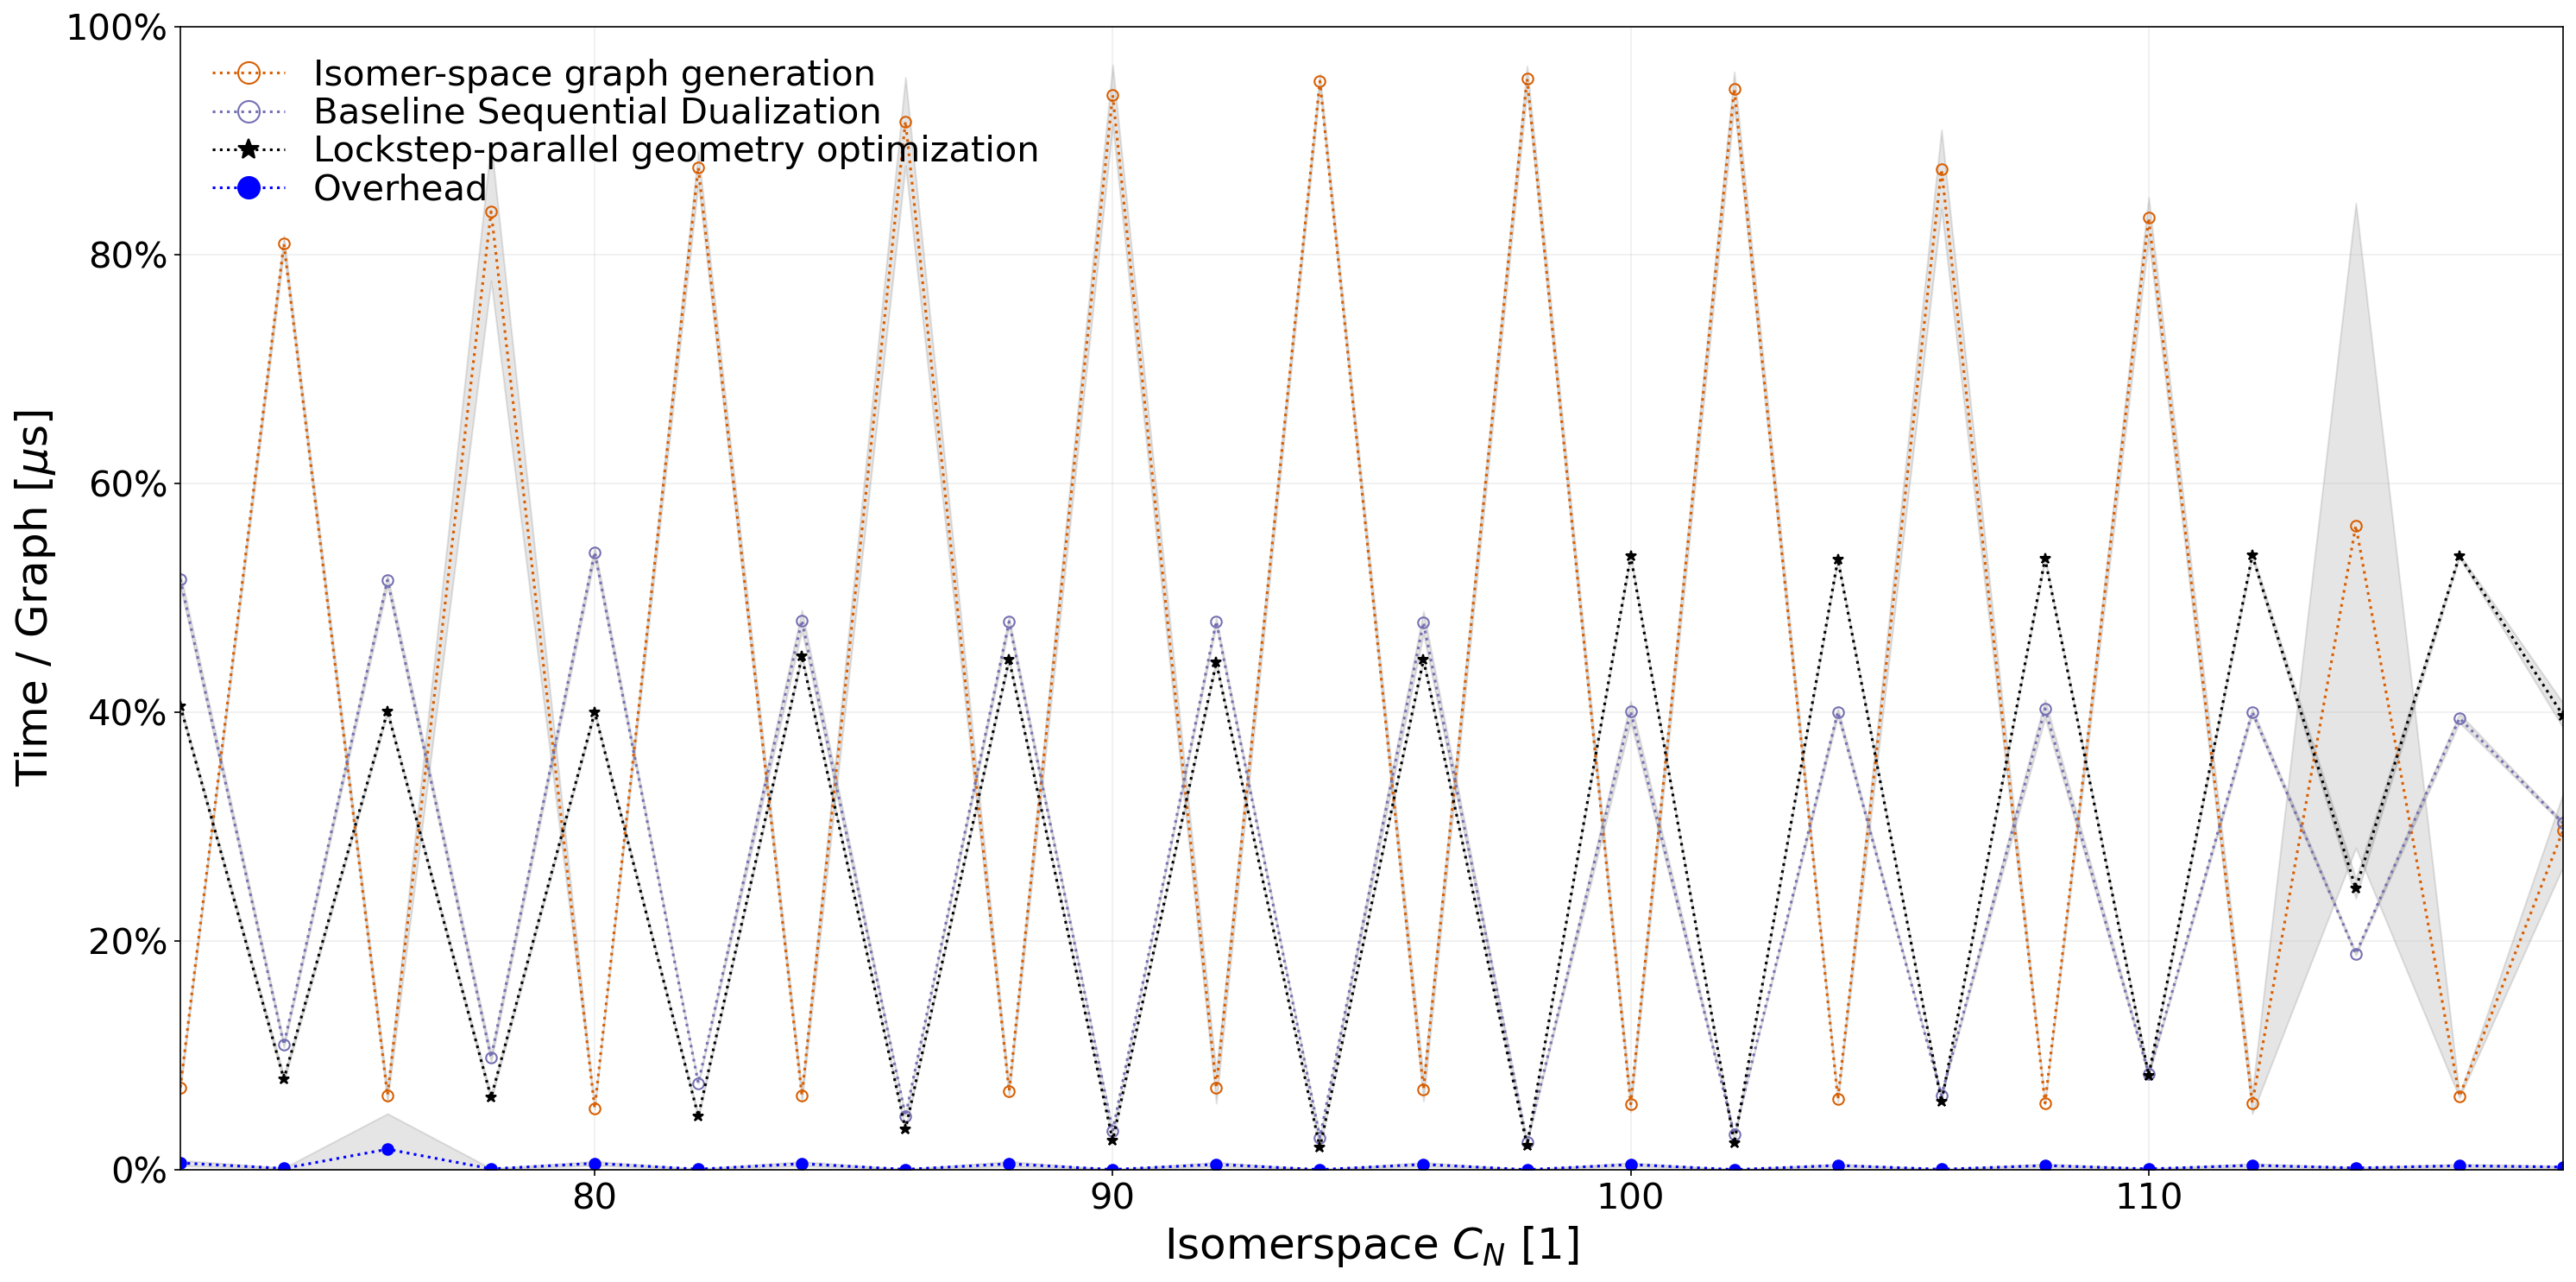

In [68]:
import matplotlib.ticker as ticker

df_base_pipeline = pd.read_csv(fname_base_pipeline)

fig, ax = plt.subplots(figsize=(20,10), nrows=1, sharex=True, dpi=150)

opt = df_base_pipeline["T_opt"].to_numpy()
opt_sd = df_base_pipeline["TSD_opt"].to_numpy()
tutte = df_base_pipeline["T_tutte"].to_numpy()
tutte_sd = df_base_pipeline["TSD_tutte"].to_numpy()
project = df_base_pipeline["T_project"].to_numpy()
project_sd = df_base_pipeline["TSD_project"].to_numpy()
overhead = df_base_pipeline["T_overhead"].to_numpy()
overhead_sd = df_base_pipeline["TSD_overhead"].to_numpy()
gen = df_base_pipeline["T_gen"].to_numpy()
gen_sd = df_base_pipeline["TSD_gen"].to_numpy()
dual = df_base_pipeline["T_dual"].to_numpy()
dual_sd = df_base_pipeline["TSD_dual"].to_numpy()
natoms = df_base_pipeline["N"].to_numpy()


parallel = opt + tutte + project
parallel_sd = np.sqrt(opt_sd**2 + tutte_sd**2 + project_sd**2)
total = parallel + overhead + gen + dual

def plot_line_normalized(ax, x, y, y_sd, label, color, marker, linestyle, mfc_bool=True):
    if mfc_bool:
        ax.plot(x, 1e2* y/total, marker=marker, color=color, label=label, linestyle=linestyle, mfc=color) #Normalized to total time, shown as percentage
    else:
        ax.plot(x, 1e2* y/total, marker=marker, color=color, label=label, linestyle=linestyle, mfc="None") #Normalized to total time, shown as percentage
    ax.fill_between(x, 1e2*(y - y_sd)/total, 1e2*(y + y_sd)/total, alpha=0.1, color='k')


plot_line_normalized(ax, natoms, gen, gen_sd, "Isomer-space graph generation", CD["Generate"], 'o', ':', False)
plot_line_normalized(ax, natoms, dual, dual_sd, "Baseline Sequential Dualization", CD["Dual"], 'o', ':', False)
plot_line_normalized(ax, natoms, parallel, parallel_sd, "Lockstep-parallel geometry optimization", "k", '*', ':')
plot_line_normalized(ax, natoms, overhead, overhead_sd, "Overhead", "blue", 'o', ':')

ax.set_ylabel(r"Time / Graph [$\mu$s]")
ax.legend()
ax.set_xlabel(r"Isomerspace $C_N$ [1]")
ax.set_ylim(0,100)
#percentage formatting
ax.yaxis.set_major_formatter(ticker.PercentFormatter())



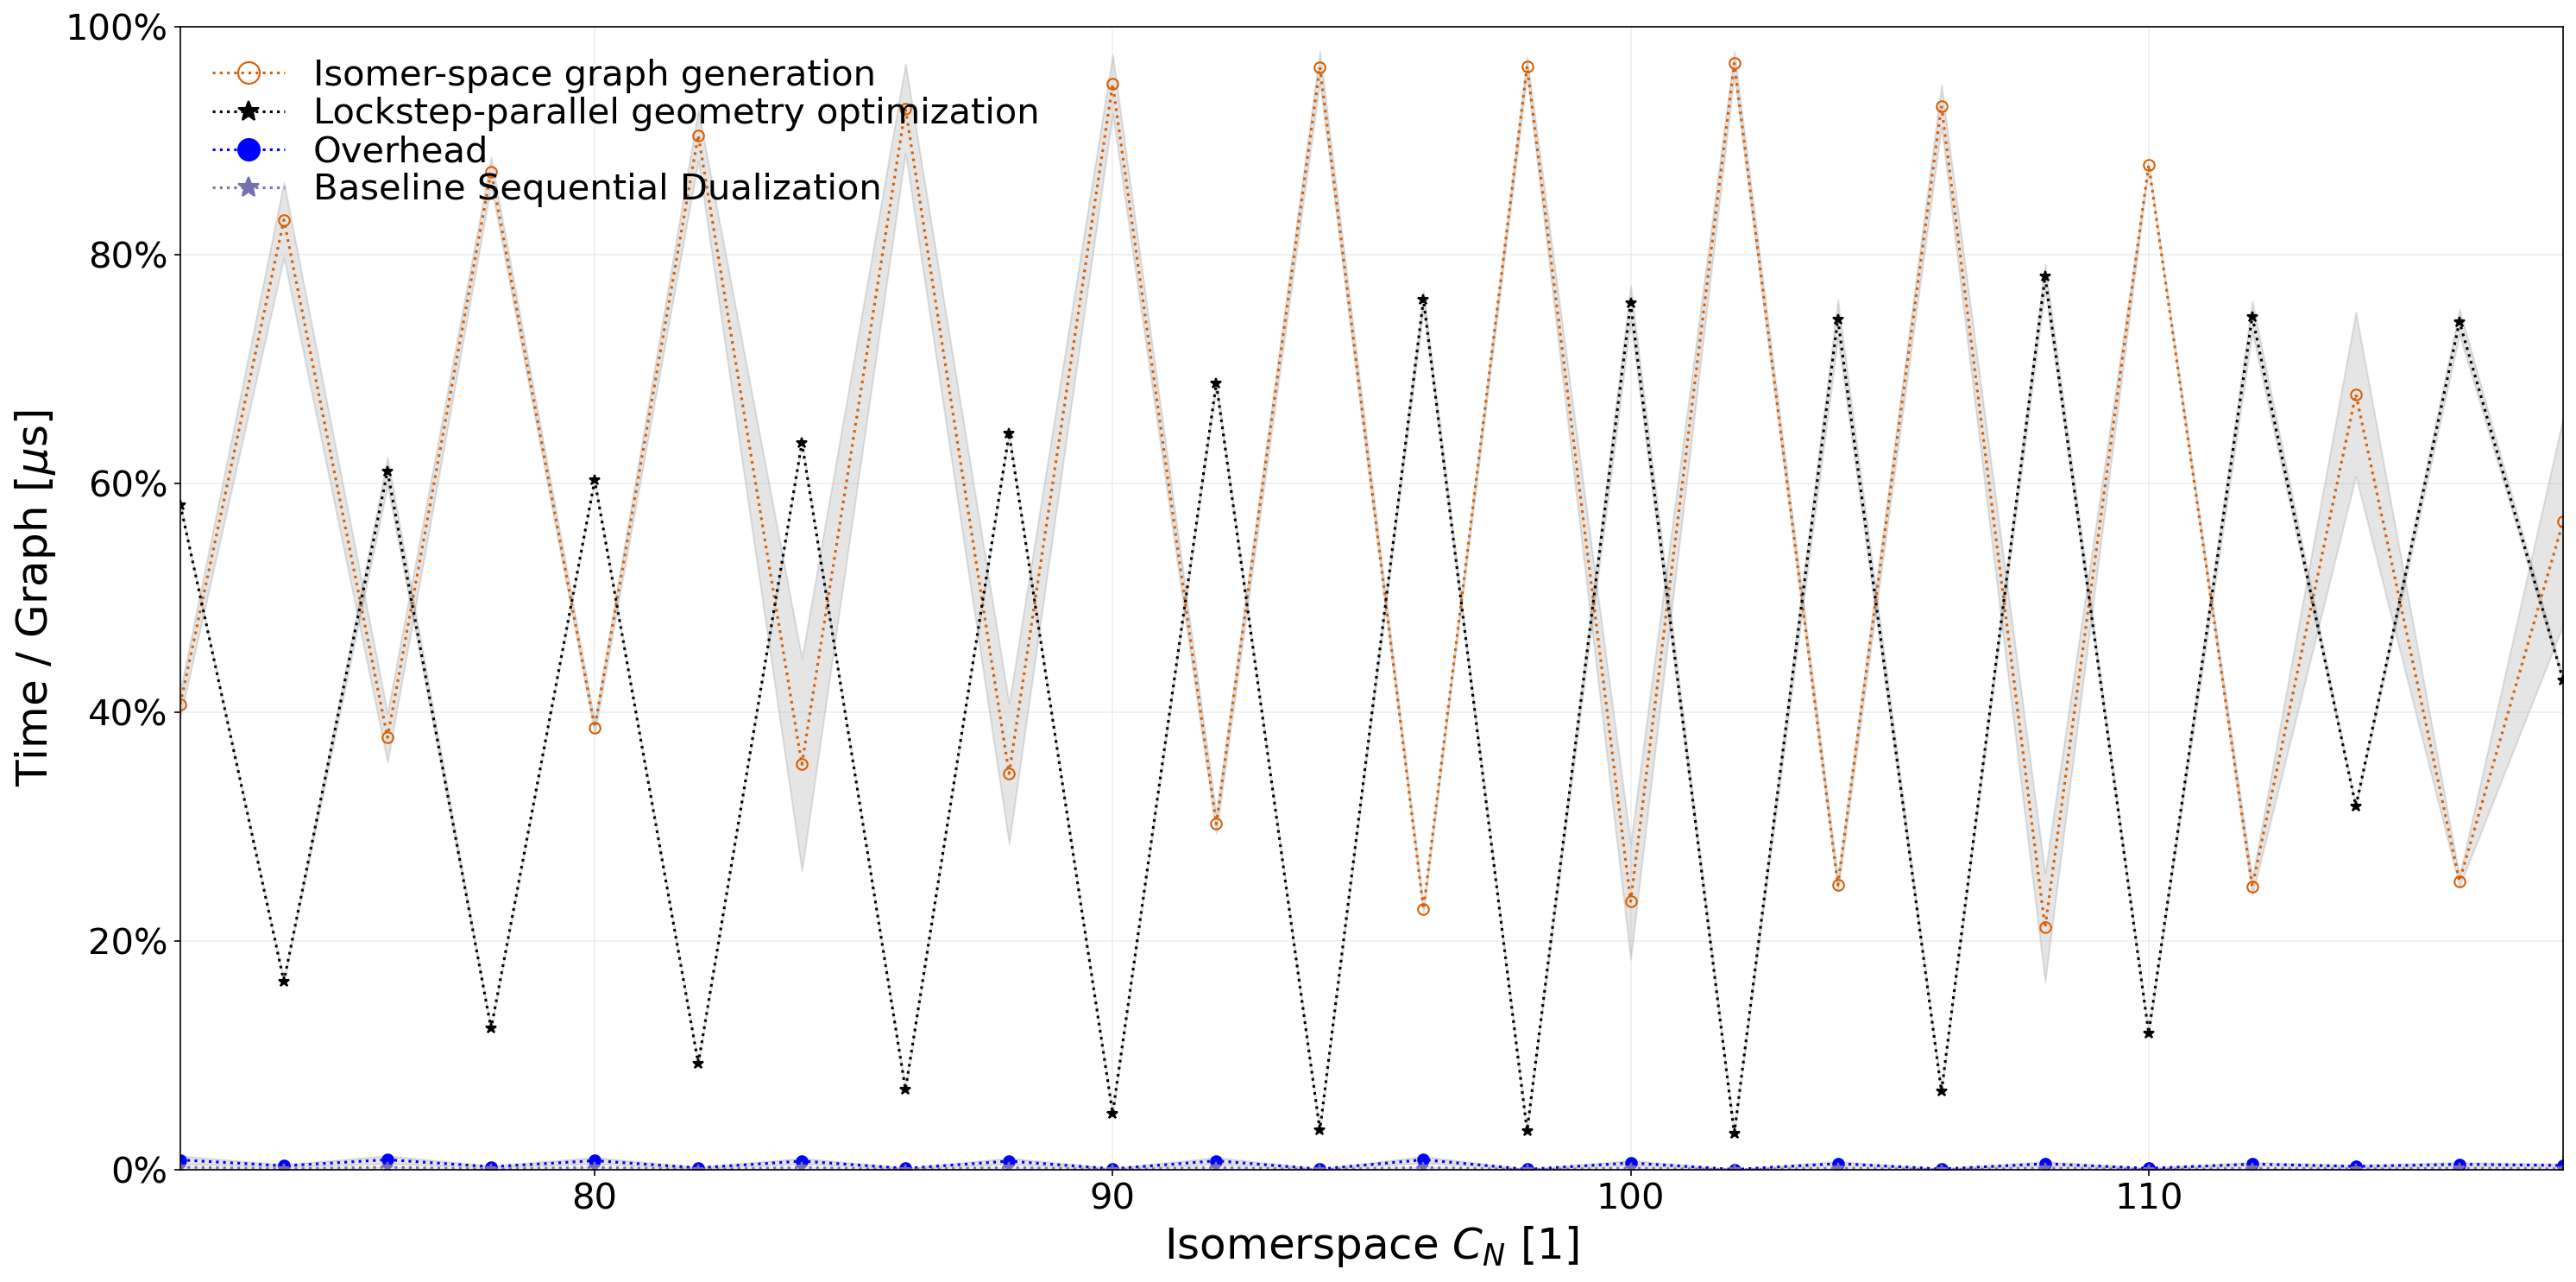

In [69]:
import matplotlib.ticker as ticker

df_full_pipeline = pd.read_csv(fname_full_pipeline)

fig, ax = plt.subplots(figsize=(20,10), nrows=1, sharex=True, dpi=150)

opt = df_full_pipeline["T_opt"].to_numpy()
opt_sd = df_full_pipeline["TSD_opt"].to_numpy()
tutte = df_full_pipeline["T_tutte"].to_numpy()
tutte_sd = df_full_pipeline["TSD_tutte"].to_numpy()
project = df_full_pipeline["T_project"].to_numpy()
project_sd = df_full_pipeline["TSD_project"].to_numpy()
overhead = df_full_pipeline["T_overhead"].to_numpy()
overhead_sd = df_full_pipeline["TSD_overhead"].to_numpy()
gen = df_full_pipeline["T_gen"].to_numpy()
gen_sd = df_full_pipeline["TSD_gen"].to_numpy()
dual = df_full_pipeline["T_dual"].to_numpy()
dual_sd = df_full_pipeline["TSD_dual"].to_numpy()
natoms = df_full_pipeline["N"].to_numpy()


parallel = opt + tutte + project
parallel_sd = np.sqrt(opt_sd**2 + tutte_sd**2 + project_sd**2)
total = parallel + overhead + gen + dual

def plot_normalized_line(ax, x, y, y_sd, label, color, marker, linestyle, mfc_bool=True):
    if mfc_bool:
        ax.plot(x, 1e2* y/total, marker=marker, color=color, label=label, linestyle=linestyle, mfc=color) #Normalized to total time, shown as percentage
    else:
        ax.plot(x, 1e2* y/total, marker=marker, color=color, label=label, linestyle=linestyle, mfc="None") #Normalized to total time, shown as percentage
    ax.fill_between(x, 1e2*(y - y_sd)/total, 1e2*(y + y_sd)/total, alpha=0.1, color='k')


plot_normalized_line(ax, natoms, gen, gen_sd, "Isomer-space graph generation", CD["Generate"], 'o', ':', False)
plot_normalized_line(ax, natoms, parallel, parallel_sd, "Lockstep-parallel geometry optimization", "k", '*', ':')
plot_normalized_line(ax, natoms, overhead, overhead_sd, "Overhead", "blue", 'o', ':')
plot_normalized_line(ax, natoms, dual, dual_sd, "Baseline Sequential Dualization", CD["Dual"], '*', ':')

ax.set_ylabel(r"Time / Graph [$\mu$s]")
ax.legend()
ax.set_xlabel(r"Isomerspace $C_N$ [1]")
ax.set_ylim(0,100)
#percentage formatting
ax.yaxis.set_major_formatter(ticker.PercentFormatter())


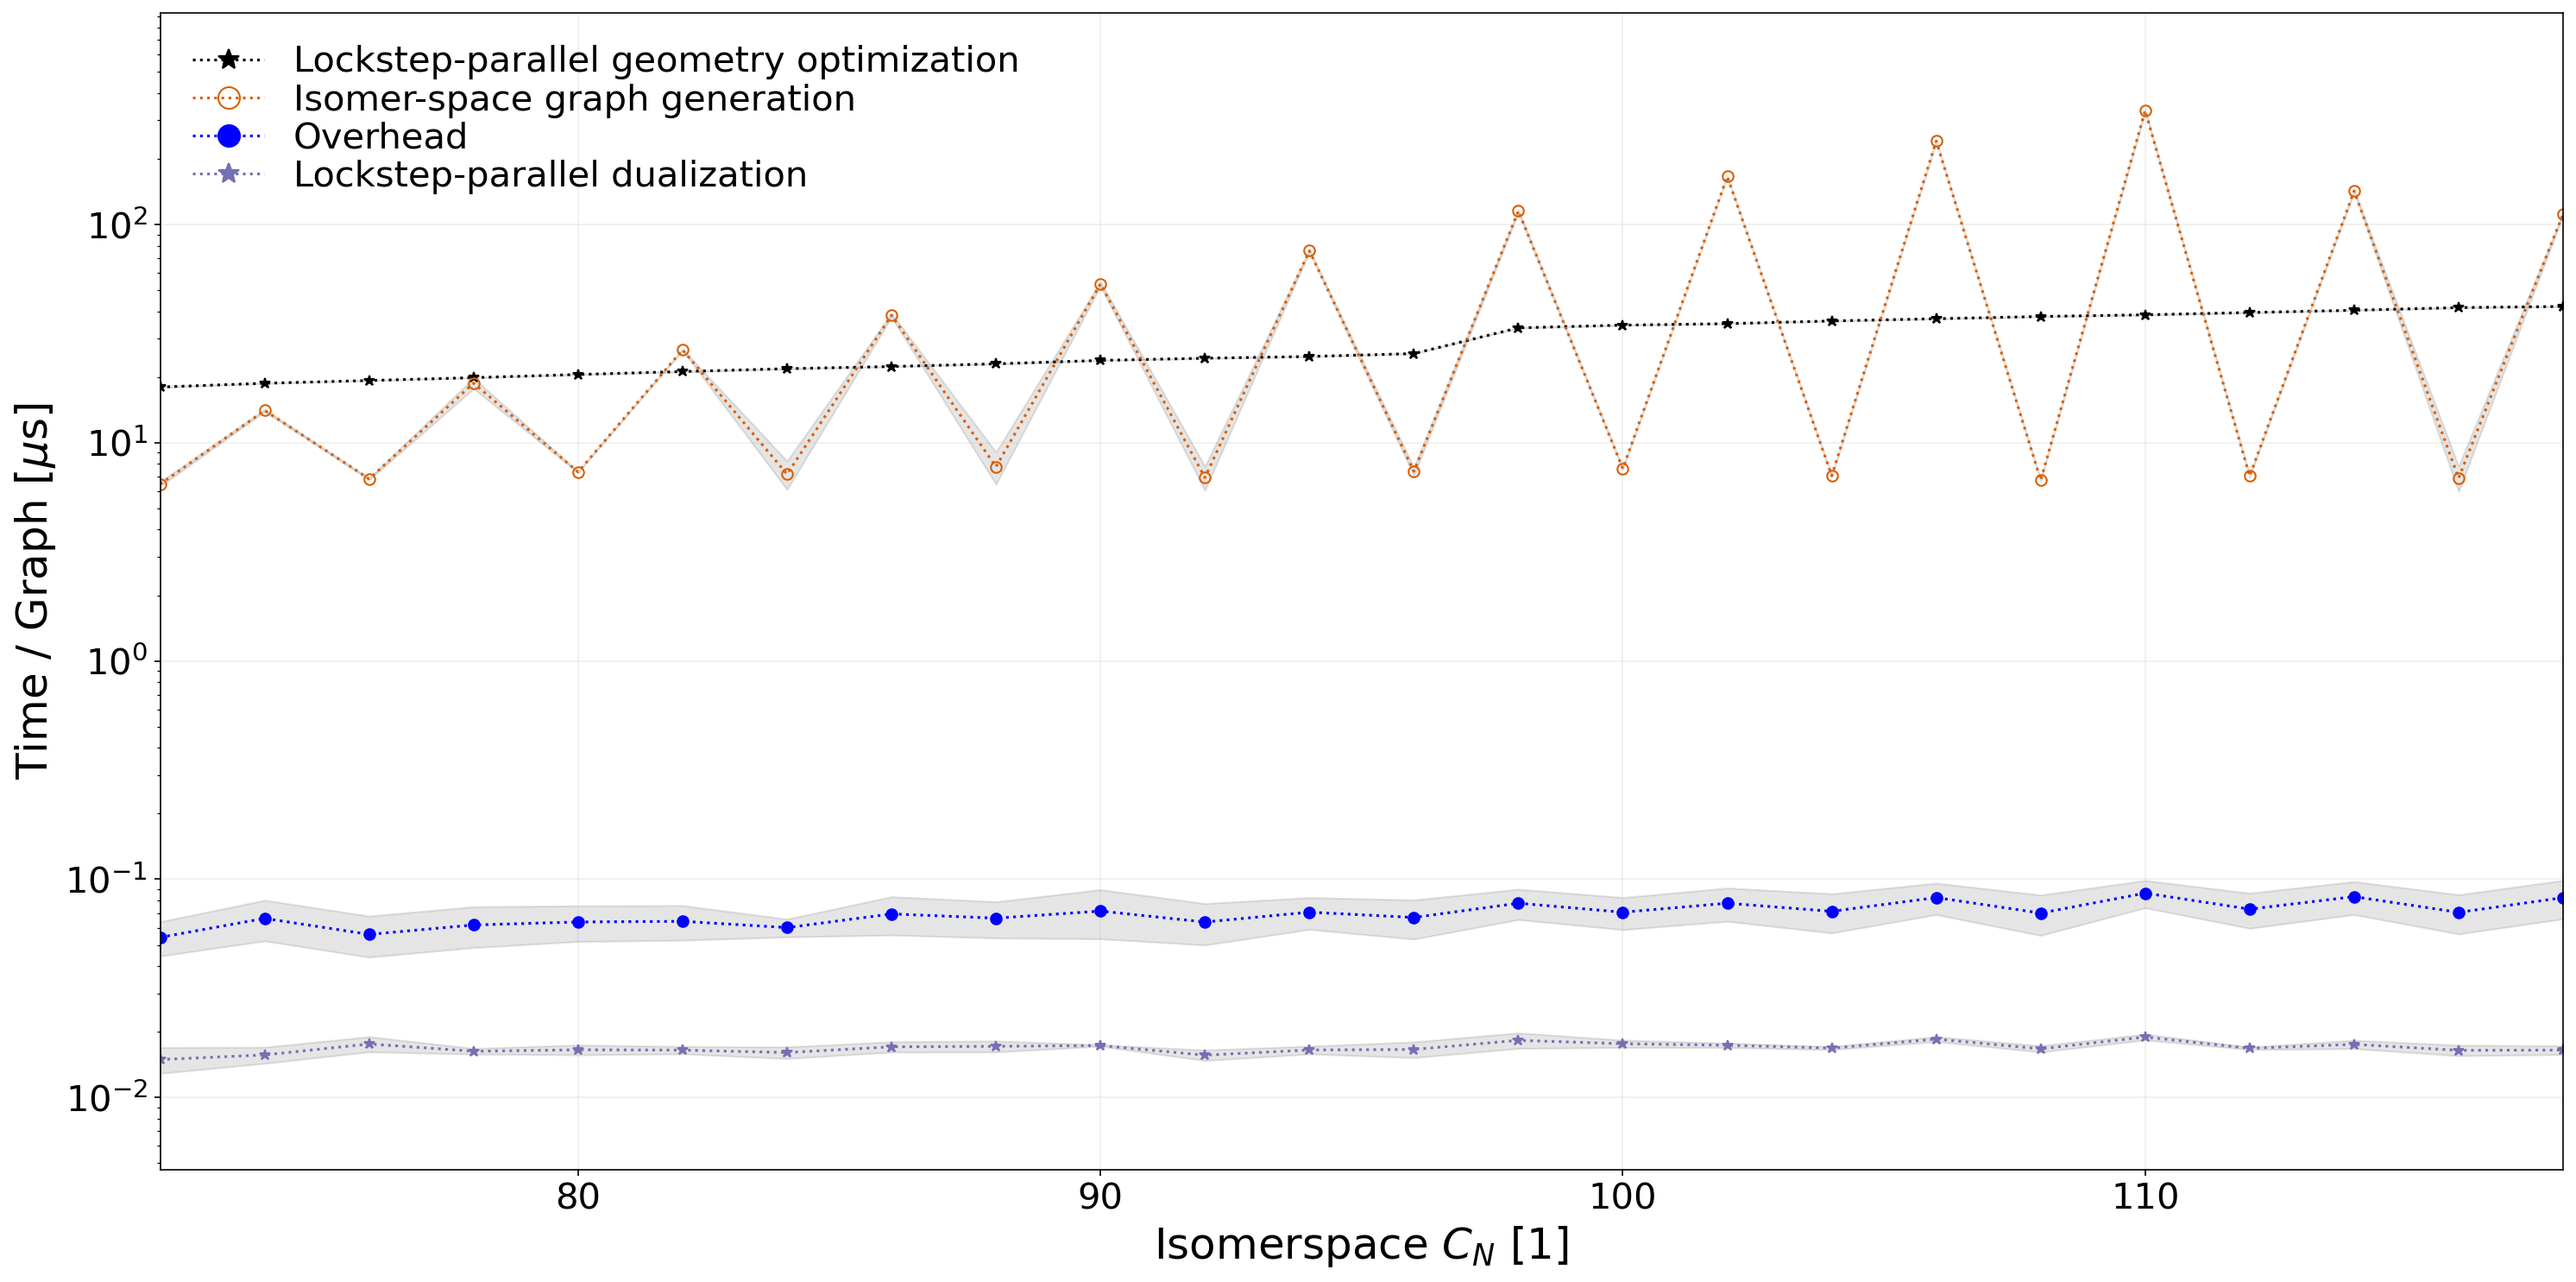

In [75]:
import matplotlib.ticker as ticker

df_full_pipeline = pd.read_csv(fname_full_pipeline)

fig, ax = plt.subplots(figsize=(20,10), nrows=1, sharex=True, dpi=150)

opt = df_full_pipeline["T_opt"].to_numpy()
opt_sd = df_full_pipeline["TSD_opt"].to_numpy()
tutte = df_full_pipeline["T_tutte"].to_numpy()
tutte_sd = df_full_pipeline["TSD_tutte"].to_numpy()
project = df_full_pipeline["T_project"].to_numpy()
project_sd = df_full_pipeline["TSD_project"].to_numpy()
overhead = df_full_pipeline["T_overhead"].to_numpy()
overhead_sd = df_full_pipeline["TSD_overhead"].to_numpy()
gen = df_full_pipeline["T_gen"].to_numpy()
gen_sd = df_full_pipeline["TSD_gen"].to_numpy()
dual = df_full_pipeline["T_dual"].to_numpy()
dual_sd = df_full_pipeline["TSD_dual"].to_numpy()
natoms = df_full_pipeline["N"].to_numpy()


parallel = opt + tutte + project
parallel_sd = np.sqrt(opt_sd**2 + tutte_sd**2 + project_sd**2)
total = parallel + overhead + gen + dual

def plot_absolute_line(ax, x, y, y_sd, label, color, marker, linestyle, mfc_bool=True):
    if mfc_bool:
        ax.plot(x,  y/1e3, marker=marker, color=color, label=label, linestyle=linestyle, mfc=color) #Normalized to total time, shown as percentage
    else:
        ax.plot(x,  y/1e3, marker=marker, color=color, label=label, linestyle=linestyle, mfc="None") #Normalized to total time, shown as percentage
    ax.fill_between(x, (y - y_sd)/1e3, (y + y_sd)/1e3, alpha=0.1, color='k')


plot_absolute_line(ax, natoms, parallel, parallel_sd, "Lockstep-parallel geometry optimization", "k", '*', ':')
plot_absolute_line(ax, natoms, gen, gen_sd, "Isomer-space graph generation", CD["Generate"], 'o', ':', False)
plot_absolute_line(ax, natoms, overhead, overhead_sd, "Overhead", "blue", 'o', ':')
plot_absolute_line(ax, natoms, dual, dual_sd, "Lockstep-parallel dualization", CD["Dual"], '*', ':')

ax.set_ylabel(r"Time / Graph [$\mu$s]")
ax.legend()
ax.set_xlabel(r"Isomerspace $C_N$ [1]")
ax.set_yscale('log')
#percentage formatting

### Speedup of the V1 Kernel (SYCL) on 1 GPU compared to sequential CPU dualization

In [1]:
#Speedup of dualization plot
fig, ax = plt.subplots(figsize=(20,10), nrows=1, sharex=True, dpi=150)

sequential = df_base_pipeline["T_dual"].to_numpy()
sequential_sd = df_base_pipeline["TSD_dual"].to_numpy()
parallel = df_full_pipeline["T_dual"].to_numpy()
parallel_sd = df_full_pipeline["TSD_dual"].to_numpy()
natoms = df_full_pipeline["N"].to_numpy()

speedup = sequential / parallel
speedup_sd = np.sqrt((sequential_sd/sequential)**2 + (parallel_sd/parallel)**2) * speedup

ax.plot(natoms, speedup, 'o:', color="r", label="Speedup")
ax.fill_between(natoms, speedup - speedup_sd, speedup + speedup_sd, alpha=0.1, color='k')
ax.set_ylabel(r"Speedup [1]")
ax.legend()
ax.set_xlabel(r"Isomerspace $C_N$ [1]")


NameError: name 'plt' is not defined

### Speedup Chart of the various parallelization techniques

In [ ]:

fig, ax     = plt.subplots(figsize=(15,10), nrows=1)
StartOffset = 36 #Start at saturation
#Plot the speedup of the different algorithms

dfbase = pd.read_csv(fname_base)
df1 = pd.read_csv(fname_omp_shared)
df2 = pd.read_csv(fname_omp_task)
df3 = pd.read_csv(fname_one_gpu_v1)
df4 = pd.read_csv(fname_multi_gpu_v1)

MeanBaseline = np.mean(dfbase["T"].to_numpy()[StartOffset:]); BaselineSD = np.std(dfbase["T"].to_numpy()[StartOffset:])
MeanShared = np.mean(df1["T"].to_numpy()[StartOffset:]); SharedSD = np.std(df1["T"].to_numpy()[StartOffset:])
MeanTask = np.mean(df2["T"].to_numpy()[StartOffset:]); TaskSD = np.std(df2["T"].to_numpy()[StartOffset:])
MeanGPU = np.mean(df3["T"].to_numpy()[StartOffset:]); GPUSD = np.std(df3["T"].to_numpy()[StartOffset:])
MeanGPU2 = np.mean(df4["T"].to_numpy()[StartOffset:]); GPU2SD = np.std(df4["T"].to_numpy()[StartOffset:])

MeanTime = np.array([MeanBaseline, MeanShared, MeanTask, MeanGPU, MeanGPU2])
MeanSD = np.array([BaselineSD, SharedSD, TaskSD, GPUSD, GPU2SD])
def std_div(a,b, a_std, b_std):
    return a/b * np.sqrt((a_std/a)**2 + (b_std/b)**2)

SpeedupSD = std_div(MeanBaseline, MeanTime, BaselineSD, MeanSD)
SpeedupSD[0] = 0
Speedup = MeanBaseline / MeanTime


color_bar = [CD["Baseline"], CD["Shared"], CD["Task"], CD["GPU_V1"], CD["2 GPU_V1"]]


if num_gpus>1:
    p1 = ax.bar(np.arange(5), Speedup, color= color_bar, yerr=SpeedupSD, capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
elif num_gpus>0:
    p1 = ax.bar(np.arange(4), Speedup[:-1], color= color_bar[:-1], yerr=SpeedupSD[:-1], capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
else:
    p1 = ax.bar(np.arange(3), Speedup[:-2], color= color_bar[:-2], yerr=SpeedupSD[:-2], capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
ax.set_yscale("log")
ax.set_ylabel(r"Speedup [1]")
ax.grid(False)
ax.set_xticklabels([r"Baseline",r"Baseline", r"Shared [$N_T$ = " + f"{NT_shared}]", r"Task [$N_T$ = " + f"{NT_task}]", r"1 GPU", r"2 GPUs"])

ax.set_xlim(-0.5,4.5)

In [ ]:
#Plot the speedup of the different algorithms

dfbase = pd.read_csv(fname_base)
df1 = pd.read_csv(fname_omp_shared)
df2 = pd.read_csv(fname_omp_task)
df3 = pd.read_csv(fname_one_gpu_v1)
df4 = pd.read_csv(fname_multi_gpu_v1)

MeanBaseline = np.mean(dfbase["T"].to_numpy()[StartOffset:]); BaselineSD = np.std(dfbase["T"].to_numpy()[StartOffset:])
MeanShared = np.mean(df1["T"].to_numpy()[StartOffset:]); SharedSD = np.std(df1["T"].to_numpy()[StartOffset:])
MeanTask = np.mean(df2["T"].to_numpy()[StartOffset:]); TaskSD = np.std(df2["T"].to_numpy()[StartOffset:])
MeanGPU = np.mean(df3["T"].to_numpy()[StartOffset:]); GPUSD = np.std(df3["T"].to_numpy()[StartOffset:])
MeanGPU2 = np.mean(df4["T"].to_numpy()[StartOffset:]); GPU2SD = np.std(df4["T"].to_numpy()[StartOffset:])

MeanTime = np.array([MeanBaseline, MeanShared, MeanTask, MeanGPU, MeanGPU2])
MeanSD = np.array([BaselineSD, SharedSD, TaskSD, GPUSD, GPU2SD])
def std_div(a,b, a_std, b_std):
    return a/b * np.sqrt((a_std/a)**2 + (b_std/b)**2)

SpeedupSD = std_div(MeanBaseline, MeanTime, BaselineSD, MeanSD)
SpeedupSD[0] = 0
Speedup = MeanBaseline / MeanTime


color_bar = [CD["Baseline"], CD["Shared"], CD["Task"], CD["GPU_V1"], CD["2 GPU_V1"]]


if num_gpus>1:
    p1 = ax.bar(np.arange(5), Speedup, color= color_bar, yerr=SpeedupSD, capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
elif num_gpus>0:
    p1 = ax.bar(np.arange(4), Speedup[:-1], color= color_bar[:-1], yerr=SpeedupSD[:-1], capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
else:
    p1 = ax.bar(np.arange(3), Speedup[:-2], color= color_bar[:-2], yerr=SpeedupSD[:-2], capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
ax.set_yscale("log")
ax.set_ylabel(r"Speedup [1]")
ax.grid(False)
ax.set_xticklabels([r"Baseline",r"Baseline", r"Shared [$N_T$ = " + f"{NT_shared}]", r"Task [$N_T$ = " + f"{NT_task}]", r"1 GPU", r"2 GPUs"])

ax.set_xlim(-0.5,4.5)